In [38]:
import os
import pandas as pd
from collections import defaultdict
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(font_scale=1.5, style="ticks")

all_results = list()

subtype = "h3n2"

month="02"

our_model="VaxSeer"

seq_threshold = 0.4 #

output_paths = []
all_dfs = []
model2df = defaultdict(list)
for year in range(2012, 2022): # 2022
    domiance_models_map = {
        "history_%d" % ((year - 2018) * 2 + 30 - 2): "Last", 
        "lightning_logs_version_0": our_model,
        "lm_lightning_logs_version_0": "LM",
        "aa_subs": "AA sub",
        "evescape": "EVEscape",
        "viral_mut_cscs": "CSCS",
#         "max_steps_100k": "max_steps_100k"
    }
    hi_models = {
        "exp_before_%d-%s_avg" % (year, month): "Avg",
        "exp_before_%d-%s_blosum" % (year, month): "BLOSUM",
        "aa_subs": "LR+",
        "cnn": "CNN",
#         "lightning_logs_version_0": our_model,
        "max_steps_150k": our_model
    }

    vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=%d-%s-%d-%s___virus_set=%d-%s-%d-%s/vaccine_scores" % \
                            (year, month, subtype, year-3, month, year, month, year-3, month, year, month)


    for file in os.listdir(vaccine_scores_path):
        model_key = None

        prob_file, exp_file = file.split("___")
        prob_file = prob_file.split("prob=")[1]
        exp_file = exp_file.split("hi=")[1]
        if prob_file in domiance_models_map and exp_file in  hi_models:
            model_key = domiance_models_map[prob_file] + "___" + hi_models[exp_file]
            _df = pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv"))
            _df["year"] = [str(year)] * len(_df)
            model2df[model_key].append(_df)

            if model_key == "%s___%s" % (our_model, our_model):
                df = pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv"))
                df["year"] = [str(year)] * len(df)
                all_dfs.append(df)


for model in model2df:
    model2df[model] = pd.concat(model2df[model])

all_dfs = pd.concat(all_dfs)

result_matrix_seq = []
result_matrix_seq_pvalue = []
# print("Model,Threshold,Clade-R,P,Seq-R,P,#vaccine_clade,#vaccine_seq,Clade-RMSE,Seq-RMSE")
for model in model2df:
    
    mask_seq = ~np.isnan(model2df[model]["gt_score_seq"])
    mask_seq = np.logical_and(mask_seq, model2df[model]["coverage_seq"]>seq_threshold)
    
    spearman_rank_seq, pvalue_seq = stats.spearmanr(model2df[model]["score"][mask_seq], model2df[model]["gt_score_seq"][mask_seq])

    result_matrix_seq.append((model.split("___")[0], model.split("___")[1], spearman_rank_seq))
    result_matrix_seq_pvalue.append((model.split("___")[0], model.split("___")[1], pvalue_seq))

    all_results.append([model, seq_threshold, spearman_rank_seq, pvalue_seq, mask_seq.sum()])

    if model == "%s___%s" % (our_model, our_model):
        our_res_seq = (spearman_rank_seq, pvalue_seq)
        
all_dfs["neg_score"] = -all_dfs["score"]
all_dfs["neg_gt_score_seq"] = -all_dfs["gt_score_seq"]


In [39]:
all_results_df = pd.DataFrame(all_results,
                   columns=["model", "confidence_threshold_seq","Seq-R","Seq-P","#vaccine_seq"])



In [40]:
all_results_df["dominance model"] = [x.split("___")[0] for x in all_results_df["model"]]
all_results_df["hi model"] = [x.split("___")[1] for x in all_results_df["model"]]
all_results_df

,model,confidence_threshold_seq,Seq-R,Seq-P,#vaccine_seq,dominance model,hi model
0,EVEscape___VaxSeer,0.4,0.652865,2.079712e-07,51,EVEscape,VaxSeer
1,EVEscape___Avg,0.4,0.499627,1.894808e-04,51,EVEscape,Avg
2,VaxSeer___CNN,0.4,0.648641,2.642756e-07,51,VaxSeer,CNN
3,AA sub___Avg,0.4,0.588185,5.656239e-06,51,AA sub,Avg
4,AA sub___VaxSeer,0.4,0.583252,7.069926e-06,51,AA sub,VaxSeer
5,Last___LR+,0.4,0.589846,5.242542e-06,51,Last,LR+
6,VaxSeer___LR+,0.4,0.593588,4.411088e-06,51,VaxSeer,LR+
7,EVEscape___LR+,0.4,0.647269,2.854396e-07,51,EVEscape,LR+
8,LM___Avg,0.4,0.493699,2.318820e-04,51,LM,Avg
9,AA sub___CNN,0.4,0.589561,5.311434e-06,51,AA sub,CNN


In [41]:
cdc_vaccines = pd.read_csv("../../data/recommended_vaccines_from_gisaid.csv")

year2strains = defaultdict(list)
for year, strain in zip(cdc_vaccines["Season"], cdc_vaccines["A/%s" % subtype.upper()]):
    if "-" not in year:
        continue
#     if strain == "A/Hong_Kong/2671/2019":
#         continue
    year2strains[year.split("-")[0]].append(strain.replace(" ", "_"))
    
print(year2strains)


defaultdict(<class 'list'>, {'2023': ['A/Darwin/9/2021', 'A/Darwin/6/2021'], '2022': ['A/Darwin/9/2021', 'A/Darwin/6/2021'], '2021': ['A/Cambodia/e0826360/2020', 'A/Cambodia/e0826360/2020'], '2020': ['A/Hong_Kong/2671/2019', 'A/Hong_Kong/45/2019'], '2019': ['A/Kansas/14/2017'], '2018': ['A/Singapore/INFIMH-16-0019/2016'], '2017': ['A/Hong_Kong/4801/2014'], '2016': ['A/Hong_Kong/4801/2014'], '2015': ['A/Switzerland/9715293/2013'], '2014': ['A/Texas/50/2012'], '2013': ['A/Texas/50/2012'], '2012': ['A/Victoria/361/2011'], '2011': ['A/Perth/16/2009'], '2010': ['A/Perth/16/2009']})


In [42]:
# read WHO vaccines

who_result = defaultdict(list)

for year in range(2012, 2022):
    vaccine_scores_path = "../../runs/pipeline/%d-%s/a_%s/vaccine_set=who___virus_set=%d-%s-%d-%s/vaccine_scores" % (year, month, subtype, year-3, month, year, month)
    if not os.path.exists(vaccine_scores_path):
        continue
    for file in os.listdir(vaccine_scores_path):
        if file == "prob=lightning_logs_version_0___hi=max_steps_150k":
#         if file == "prob=lightning_logs_version_0___hi=lightning_logs_version_0":
            if os.path.exists(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")):
                res = (pd.read_csv(os.path.join(vaccine_scores_path, file, "vaccine_score_and_gt.csv")))
#                 gt_score = np.mean(res["gt_score_seq"])
                
#                 year2result[year] = -score
                gt_score = -res["gt_score_seq"]
                pred_score = -res["score"]
        
#                 mask = np.logical_and(~np.isnan(gt_score), res["coverage_seq"] > threshold)
#                 print(gt_score)
                
                pred_score = pred_score[~np.isnan(gt_score)]
                gt_score = gt_score[~np.isnan(gt_score)]
        
                coverage = res["coverage_seq"]
                gt_score = gt_score[coverage > seq_threshold]
                pred_score = pred_score[coverage > seq_threshold]
                
                who_result["neg_score"].append(np.median(pred_score))
                who_result["year"].append(str(year))
                who_result["neg_gt_score_seq"].append(np.median(gt_score))
#                 who_result["neg_score"].append({"neg_score": , "neg_gt_score_seq": np.mean(gt_score)})


In [43]:
who_result = pd.DataFrame(who_result)

who_result["Vaccine strains"] = ["Selected by WHO"] * len(who_result)
print(who_result)

   neg_score  year  neg_gt_score_seq  Vaccine strains
0  -0.351572  2012         -1.258568  Selected by WHO
1  -2.262630  2013         -4.079060  Selected by WHO
2  -3.170520  2014         -5.133292  Selected by WHO
3  -1.332630  2015         -1.560307  Selected by WHO
4  -1.626100  2016         -1.761531  Selected by WHO
5  -1.440045  2017         -1.903924  Selected by WHO
6  -1.763225  2018         -2.696965  Selected by WHO
7  -3.353205  2019         -1.794729  Selected by WHO
8  -2.836080  2020         -2.148767  Selected by WHO
9  -3.280380  2021         -3.875124  Selected by WHO


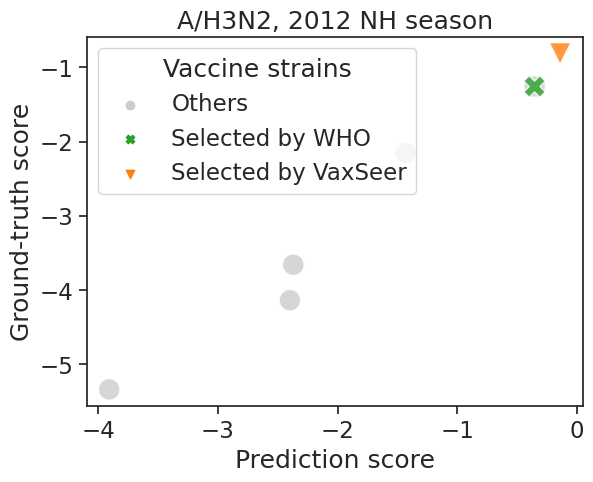

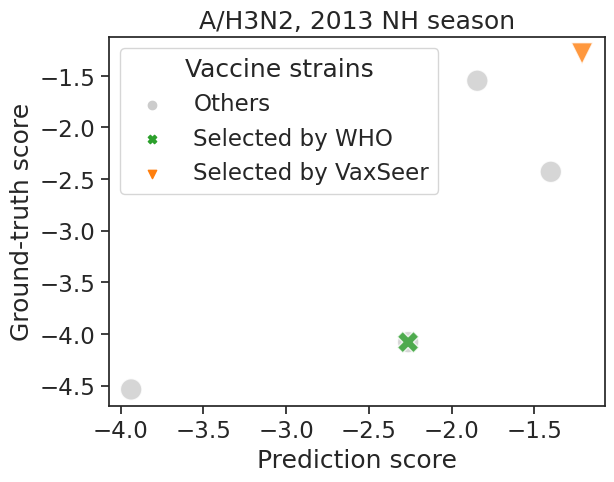

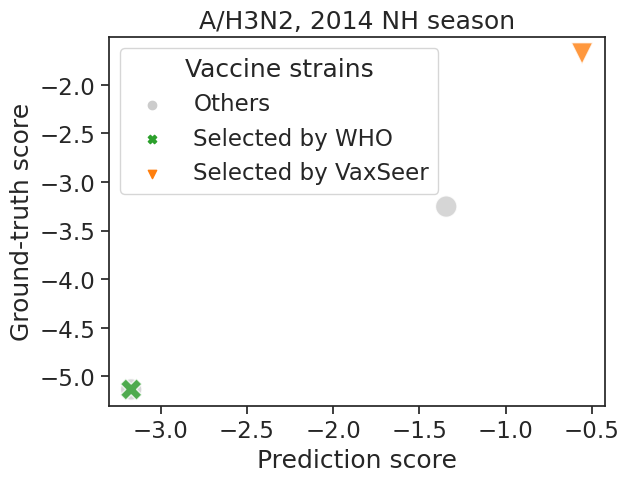

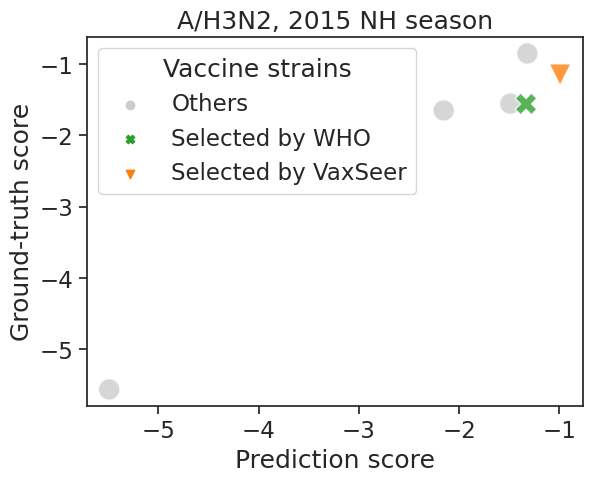

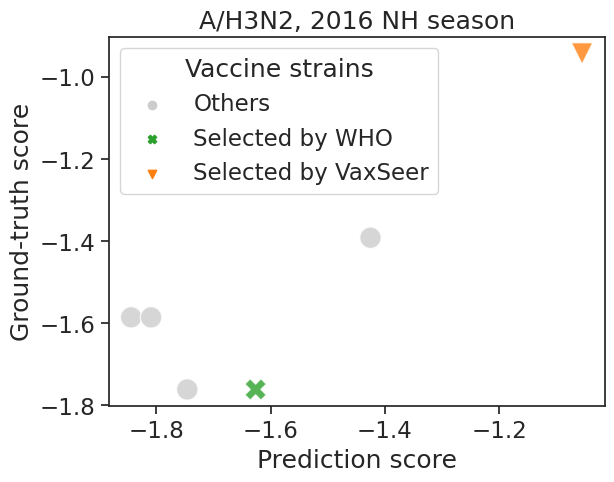

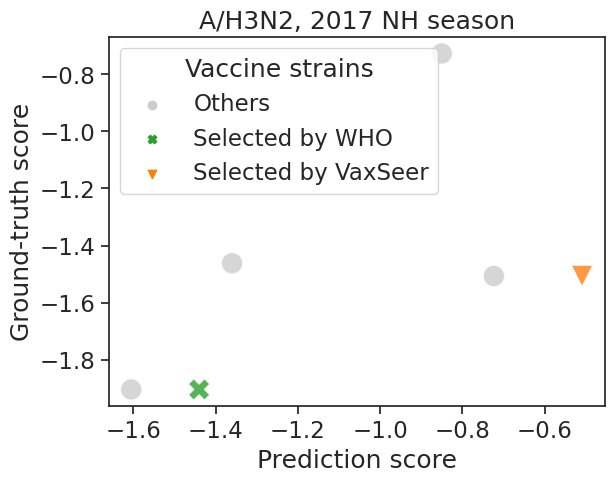

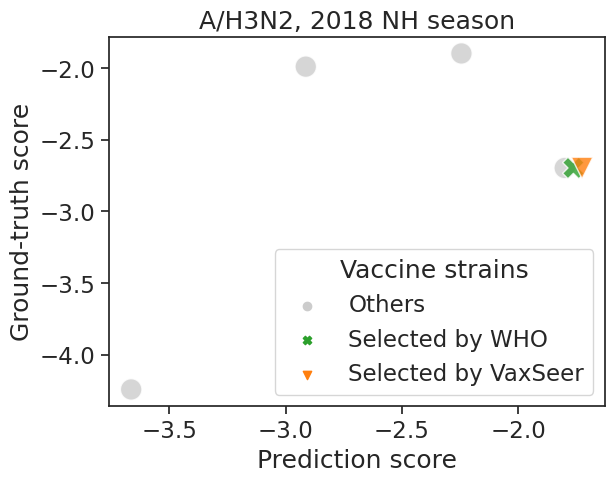

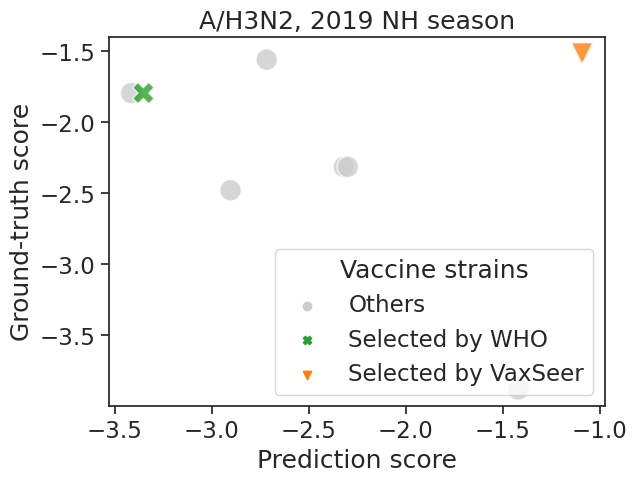

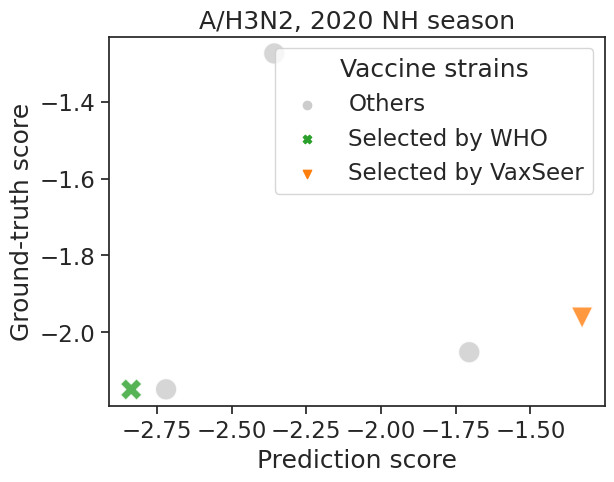

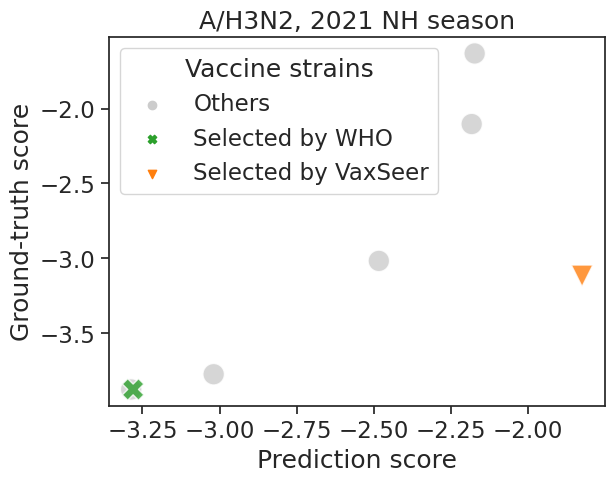

In [44]:
model_name="VaxSeer"



def order(x):
    _order = {
        "Others" : 0,
        "Selected by WHO": 1,
        "Selected by %s" % model_name: 2
    }
    return np.asarray([_order[y] for y in x])

for year in ["2012","2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021"]:
    
    all_dfs_ = all_dfs[all_dfs["year"] == year]

    def check_vaccine_name(list1, year2strains, best_score, v):
#         for y in range(int(year), int(year) + 1):
#             list2 = year2strains[str(y)]
#             for name in list1.split("|"):
#                 if name in list2:
#                     return   "Selected by WHO"
        if v == best_score: 
            return "Selected by %s" % model_name # + name
        else:
            return "Others"

    all_dfs_ = all_dfs_[all_dfs_["coverage_seq"] > seq_threshold]    
    best_score = np.max(all_dfs_["neg_score"])
    
    all_dfs_["Vaccine strains"] = [check_vaccine_name(x, year2strains, best_score, v) for v, x in zip(all_dfs_["neg_score"], all_dfs_["strain_name"])]
#     all_dfs_ = pd.concat([all_dfs_, best_score_df])
#     print(all_dfs_, who_result[who_result["year"] == year])
    all_dfs_ = pd.concat([all_dfs_, who_result[who_result["year"] == year]])
#     print(all_dfs_)
    
    all_dfs_ = all_dfs_.sort_values(by=['Vaccine strains'], key=lambda x: order(x) )
    
    
    
    ax = sns.scatterplot(data=all_dfs_, 
                         x="neg_score", 
#                          y="neg_gt_score_clade", 
                         y="neg_gt_score_seq", 
                         hue="Vaccine strains", s=240, alpha=0.8, linewidth=1.0,
                         palette={'Others':'#CCCCCC', 
                                  'Selected by %s' % model_name: 'tab:orange', 
                                  'Selected by WHO':'tab:green', 'A/Hong_Kong/45/2019': 'r'}, 
                         style="Vaccine strains",
                         markers={'Others':'o', 
                                'Selected by %s' % model_name: 'v', 
                                'Selected by WHO':'X'},
                        ) # , size="coverage_clade"
    ax.set_xlabel("Prediction score")
    ax.set_ylabel("Ground-truth score")
    ax.set(title='A/%s, %s NH season' % (subtype.upper(), year))
    if subtype == "h3n2" and year == "2019":
        plt.legend(loc='lower right', title='Vaccine strains') # 

#     plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

    # print("figs/scores_%s_year_%d.pdf" % (subtype, year))

    plt.savefig("figs/scores_%s_year_%s.pdf" % (subtype, year), format='pdf', bbox_inches='tight')
    plt.show()
    